# **Introduction**

`dlt` offers powerful tools for schema configuration, giving you control over your data processing. You can export and import schemas for easy adjustments and apply specific settings directly to resources for precise data normalization. Plus, you can set data contracts to ensure your data meets your expectations... 👀


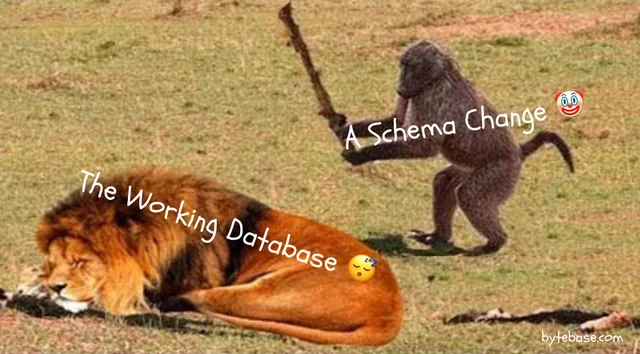

# [Refresher] **Understanding schema**

When you run a pipeline, `dlt` internally generates a `<>.schema.json` file. You can export this file to a specific location in YAML format by specifying `export_schema_path="schemas/export"` in your pipeline.

See [dlt Fundamentals: Lesson 7](https://colab.research.google.com/drive/1LokUcM5YSazdq5jfbkop-Z5rmP-39y4r#forceEdit=true&sandboxMode=true)


This YAML file will look something like:

```yaml
version: 2 # version of the schema
version_hash: xmTG0tOmE40LvzY2DbPBOnRaNNK8YlLpVP1PMO0YgyE= # hash of the actual schema content
engine_version: 9. # shema engine version of dlt
name: quick_start
tables:
  _dlt_version:
    ...
  _dlt_loads:
    ...
  _dlt_pipeline_state:
    ...
  issues:
    columns:
      url:
        data_type: text
        nullable: true
      repository_url:
        data_type: text
        nullable: true
      labels_url:
        data_type: text
        nullable: true
      ...
    write_disposition: append
    resource: get_issues
    x-normalizer:
      seen-data: true
  issues__assignees:
    columns:
      ...
    parent: issues

settings:
  detections:
  - iso_timestamp
  default_hints:
    not_null:
    - _dlt_id
    - _dlt_root_id
    - _dlt_parent_id
    - _dlt_list_idx
    - _dlt_load_id
    foreign_key:
    - _dlt_parent_id
    root_key:
    - _dlt_root_id
    unique:
    - _dlt_id
normalizers:
  names: snake_case # naming convention
  json:
    module: dlt.common.normalizers.json.relational
previous_hashes:
- O4M6U4KA32Xz4Vrdcqo4XPBPFVcK1FZbgRu5qcMfjn4=
- 0DQRnVWANYV21yD0T5nsoUtdTeq0/jIOYMUxpPE6Fcc=
```

## **Tables and columns**

A `table schema` may have the following properties:

- `name`
- `description`
- `parent`: The name of the parent table if this is a child table.
- `columns`: A list of column schemas defining the table's structure.
- `write_disposition`: A hint telling `dlt` how new data coming into the table should be loaded.


A `column schema` may have the following properties:

- `name`
- `description`
- `data_type`
- `precision`: Defines the precision for text, timestamp, time, bigint, binary, and decimal types.
- `scale`: Defines the scale for the decimal type.
- `is_variant`: Indicates that the column was generated as a variant of another column.

A `column schema` may have the following basic hints:

- `nullable`
- `primary_key`
- `merge_key`: Marks the column as part of the merge key used for incremental loads.
- `foreign_key`
- `root_key`: Marks the column as part of a root key, a type of foreign key that always refers to the root table.
- `unique`


A `column schema` may have the following performance hints:

- `partition`: Marks the column to be used for partitioning data.
- `cluster`: Marks the column to be used for clustering data.
- `sort`: : Marks the column as sortable or ordered; on some destinations, this may generate an index, even if the column is not unique.

> Each destination can interpret these performance hints in its own way. For example, the `cluster` hint is used by Redshift to define table distribution, by BigQuery to specify a cluster column, and is ignored by DuckDB and Postgres when creating tables.

# **Data contracts**

Data contracts are rules that help control how your data schema changes over time. They are particularly useful for maintaining the integrity and consistency of your data as it evolves.

`dlt` allows you to implement these data contracts at various levels, including the [table level](#scrollTo=zzVNMHgqNEYr), [column level](#scrollTo=Bq_9SNOMQGk_), and [data type level](#scrollTo=H9eMPvlOQHrJ). This provides granular control over how different parts of your schema evolve.

> **Note**: This Colab is based on `dlt`'s [schema contracts doc page](https://dlthub.com/docs/general-usage/schema-contracts) and includes additional code examples. It's still a good idea to check out the doc page for all the details.

To get started with data contracts, first install `dlt`:

In [5]:
%%capture

# Install dlt
!pip install dlt[duckdb]

###**Table level**

On the table level, you can specify `evolve` or `freeze` as part of the schema contract.

- `evolve`: Allows the creation of new tables within the schema.
- `freeze`: Prevents any changes to the schema, ensuring no new tables can be added.

Before diving into the modes above, let's load some sample data into a DuckDB database.
  > You'll find the database stored in the `Files` section on the left sidebar.

In [6]:
import dlt

# Sample data to be loaded
data = [
    {"id": 1, "name": "Alice"},
    {"id": 2, "name": "Bob"}]

# Create a dlt pipeline
table_pipeline = dlt.pipeline(
    pipeline_name="data_contracts_table_level", destination="duckdb", dataset_name="mydata"
)

# Load the data to the "users" table
load_info = table_pipeline.run(data, table_name="users")
print(load_info)

# Print the row counts for each table that was loaded in the last run of the pipeline
print("\nNumber of new rows loaded into each table: ", table_pipeline.last_trace.last_normalize_info.row_counts)

Pipeline data_contracts_table_level load step completed in 0.12 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata
The duckdb destination used duckdb:////content/data_contracts_table_level.duckdb location to store data
Load package 1746872746.2756898 is LOADED and contains no failed jobs

Number of new rows loaded into each table:  {'users': 2}


Now, try out the `evolve` mode at the table level by loading the same sample data into the same database, but this time into a new table called `new_users`.

In [7]:
# Define a dlt resource that allows the creation of new tables
@dlt.resource(schema_contract={"tables": "evolve"})
def allow_new_tables(input_data):
  yield input_data

# Run the pipeline again with the above dtl resource to load the same data into a new table "new_users"
load_info = table_pipeline.run(allow_new_tables(data), table_name="new_users")
print(load_info)

# Print the row counts for each table that was loaded in the last run of the pipeline
print("\nNumber of new rows loaded into each table: ", table_pipeline.last_trace.last_normalize_info.row_counts)

Pipeline data_contracts_table_level load step completed in 0.12 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata
The duckdb destination used duckdb:////content/data_contracts_table_level.duckdb location to store data
Load package 1746872746.6058877 is LOADED and contains no failed jobs

Number of new rows loaded into each table:  {'new_users': 2}


The `freeze` mode at the table level, as mentioned earlier, won't allow any changes to the schema, so the pipeline run below that tries to create another table with the name `newest_users` will fail 👇

In [9]:
# Define a dlt resource that prevents any changes to the schema at the table level (no new tables can be added)
@dlt.resource(schema_contract={"tables": "freeze"})
def no_new_tables(input_data):
  yield input_data

# Now, run the pipeline with the resource above, attempting to load the same data into "newest_users".
# This will fail, as new tables can't be added.
load_info = table_pipeline.run(no_new_tables(data), table_name="newest_users")
print(load_info)

PipelineStepFailed: Pipeline execution failed at stage extract when processing package 1746872763.647 with exception:

<class 'dlt.common.schema.exceptions.DataValidationError'>
In schema: data_contracts_table_level: In Schema: data_contracts_table_level Table: newest_users  . Contract on tables with mode freeze is violated. Trying to add table newest_users but new tables are frozen.

###**Column level**
At the column level, you can specify:
- `evolve`: Allows for the addition of new columns or changes in the existing ones.
- `freeze`: Prevents any changes to the existing columns.
- `discard_row`: Skips rows that have new columns but loads those that follow the existing schema.
- `discard_value`: Doesn't skip entire rows. Instead, it only skips the values of new columns, loading the rest of the row data.

Just like we did in the previous section, let's first load some sample data into a new database using a new pipeline.

> After you run the following code snippet, a new `data_contracts_column_level.duckdb` file should appear in `Files`.

In [10]:
import dlt

# Create a new pipeline
column_pipeline = dlt.pipeline(
    pipeline_name="data_contracts_column_level", destination="duckdb", dataset_name="mydata"
)

# Load the initial data containing columns "id" and "name" into the "users" table
load_info = column_pipeline.run([{"id": 1, "name": "Alice"}], table_name="users")
print(load_info)

Pipeline data_contracts_column_level load step completed in 0.22 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata
The duckdb destination used duckdb:////content/data_contracts_column_level.duckdb location to store data
Load package 1746872775.3146384 is LOADED and contains no failed jobs


View the loaded data using `dlt`'s `sql_client()`.

Alternatively, you can simply use the DuckDB client.

In [11]:
import duckdb
conn = duckdb.connect(f"{column_pipeline.pipeline_name}.duckdb")

conn.sql("SELECT * FROM mydata.users").df()


,id,name,_dlt_load_id,_dlt_id
0,1,Alice,1746872775.3146384,WIx2MgTWX4S4eQ


Assume that Alice ☝️ is the first user at your imaginary company, and you have now decided to collect users' ages as well.

When you load the information for your second user, Bob, who also provided his age 👇, the schema contract at the column level set to `evolve` will allow `dlt` to automatically adjust the schema in the destination database by adding a new column for "age".








In [12]:
# Define dlt resource that allows new columns in the data
@dlt.resource(schema_contract={"columns": "evolve"})
def allow_new_columns(input_data):
    yield input_data

# Now, load a new row into the same table, "users", which includes an additional column "age"
load_info = column_pipeline.run(allow_new_columns([{"id": 2, "name": "Bob", "age": 35}]), table_name="users")
print(load_info)

# View the data that has been loaded
print("\n")
conn = duckdb.connect(f"{column_pipeline.pipeline_name}.duckdb")
conn.sql("SELECT * FROM mydata.users").df()

Pipeline data_contracts_column_level load step completed in 0.07 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata
The duckdb destination used duckdb:////content/data_contracts_column_level.duckdb location to store data
Load package 1746872781.13778 is LOADED and contains no failed jobs




,id,name,_dlt_load_id,_dlt_id,age
0,1,Alice,1746872775.3146384,WIx2MgTWX4S4eQ,<NA>
1,2,Bob,1746872781.13778,iOpUI6QKW1c9nQ,35


Now, imagine your business partner, with whom you started the company, began requiring phone numbers from users. However, you weren't informed of this requriement and want to first load the data of users who provided their info before this change, i.e., users who did NOT provide their phone numbers.

In this case, you would use the `discard_row` mode - which will only load Sam's data 👇 because he didn't provide a phone number, and therefore his data complies with the schema.

In [13]:
# Define a dlt resource that skips rows that have new columns but loads those that follow the existing schema
@dlt.resource(schema_contract={"columns": "discard_row"})
def discard_row(input_data):
   yield input_data

# Attempt to load two additional rows. Only the row that follows the existing schema will be loaded
load_info = column_pipeline.run(
    discard_row([
        {"id": 3, "name": "Sam", "age": 30}, # This row will be loaded
        {"id": 4, "name": "Kate", "age": 79, "phone": "123-456-7890"} # This row will not be loaded
    ]),
    table_name="users"
)
print(load_info)

# View the data that has been loaded
print("\n")
conn = duckdb.connect(f"{column_pipeline.pipeline_name}.duckdb")
conn.sql("SELECT * FROM mydata.users").df()

Pipeline data_contracts_column_level load step completed in 0.07 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata
The duckdb destination used duckdb:////content/data_contracts_column_level.duckdb location to store data
Load package 1746872784.018899 is LOADED and contains no failed jobs




,id,name,_dlt_load_id,_dlt_id,age
0,1,Alice,1746872775.3146384,WIx2MgTWX4S4eQ,<NA>
1,2,Bob,1746872781.13778,iOpUI6QKW1c9nQ,35
2,3,Sam,1746872784.018899,oblzyoFoS7X6Gw,30


Due to some unknown reasons, you've suddenly decided that phone numbers are irrelevant altogether. From now on, you want to load all new data but without the "phone" column.

To achieve this, you can use the `discard_value` mode - which will load both Sarah's and Violetta's data 👇, regardless of whether either of them provided a phone number. However, the phone number column itself will be discarded.







In [14]:
# Define a dlt resource that only skips the values of new columns, loading the rest of the row data
@dlt.resource(schema_contract={"columns": "discard_value"})
def discard_value(input_data):
   yield input_data

# Load two additional rows. Since we're using the "discard_value" resource, both rows will be added
# However, the "phone" column in the second row will be ignored and not loaded
load_info = column_pipeline.run(
    discard_value([
        {"id": 5, "name": "Sarah", "age": "23"},
        {"id": 6, "name": "Violetta", "age": "22", "phone": "666-513-4510"}
    ]),
    table_name="users"
)
print(load_info)

# View the data that has been loaded
print("\n")
conn = duckdb.connect(f"{column_pipeline.pipeline_name}.duckdb")
conn.sql("SELECT * FROM mydata.users").df()

Pipeline data_contracts_column_level load step completed in 0.09 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata
The duckdb destination used duckdb:////content/data_contracts_column_level.duckdb location to store data
Load package 1746872787.3410723 is LOADED and contains no failed jobs




,id,name,_dlt_load_id,_dlt_id,age
0,1,Alice,1746872775.3146384,WIx2MgTWX4S4eQ,<NA>
1,2,Bob,1746872781.13778,iOpUI6QKW1c9nQ,35
2,3,Sam,1746872784.018899,oblzyoFoS7X6Gw,30
3,5,Sarah,1746872787.3410723,OQaMr/8s1Ja/yA,23
4,6,Violetta,1746872787.3410723,RkhOopR8/MklbQ,22


Eventually you decide that users' id, name and age are the only things you need for your obscure business...

So, you set the mode to `freeze`, forbidding any changes to the table schema. The attempt to violate the schema contract, as shown below 👇, will fail.

In [15]:
# Define a dlt resource that does not allow new columns in the data
@dlt.resource(schema_contract={"columns": "freeze"})
def no_new_columns(input_data):
  yield input_data

# Attempt to load a row with additional columns when the column contract is set to freeze
# This will fail as no new columns are allowed.
load_info = column_pipeline.run(
    no_new_columns([
        {"id": 7, "name": "Lisa", "age": 40, "phone": "098-765-4321"}
    ]),
    table_name="users"
)
print(load_info)

PipelineStepFailed: Pipeline execution failed at stage normalize when processing package 1746872792.0831337 with exception:

<class 'dlt.normalize.exceptions.NormalizeJobFailed'>
Job for users.a2cfab226c.typed-jsonl failed terminally in load 1746872792.0831337 with message In schema: data_contracts_column_level: In Schema: data_contracts_column_level Table: users Column: phone . Contract on columns with mode freeze is violated. Trying to add column phone to table users but columns are frozen..

### **Data type level**
At this level, you can choose:
- `evolve`: Allows any data type. This may result with variant columns upstream.
- `freeze`: Prevents any changes to the existing data types.
- `discard_row`: Omits rows with unverifiable data types.
- `discard_value`: Replaces unverifiable values with None, but retains the rest of the row data.

(*No imaginary situations in this section for the sake of variety and ease* ... 👀)

Load a sample row entry into a new database using a new pipeline.

In [16]:
import dlt

# Create a pipeline for loading data
data_type_pipeline = dlt.pipeline(
    pipeline_name="data_contracts_data_type", destination="duckdb", dataset_name="mydata"
)

# Load the initial data containing a column "age" of type int
load_info = data_type_pipeline.run([{"id": 1, "name": "Alice", "age": 24}], table_name="users")
print(load_info)

# View the data that has been loaded
print("\n")
conn = duckdb.connect(f"{data_type_pipeline.pipeline_name}.duckdb")
conn.sql("SELECT * FROM mydata.users").df()

Pipeline data_contracts_data_type load step completed in 0.36 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata
The duckdb destination used duckdb:////content/data_contracts_data_type.duckdb location to store data
Load package 1746872798.2443008 is LOADED and contains no failed jobs




,id,name,age,_dlt_load_id,_dlt_id
0,1,Alice,24,1746872798.2443008,yiQlV50NHIHOKw


Before trying out the `evolve` mode at the data type level 👇, take a moment to understand how variant columns mentioned earlier are created:
- **TLDR:** `dlt` creates a new column when the data type of a field in the incoming data can't be validated against the existing data type in the destination table.
- These variant columns will be named following the pattern `<original name>__v_<type>`, where `original_name` is the existing column name (with the data type clash) and `type` is the name of the new data type stored in the variant column.

In the example below, even though Bob's age is passed as a string, it can be validated as an integer, so it won't cause any problems.

In [17]:
# Define dlt resource that accepts all data types
@dlt.resource(schema_contract={"data_type": "evolve"})
def allow_any_data_type(input_data):
    yield input_data

# Now, load a new row where the "age" column is passed as a string but will be validated and stored as an integer
load_info = data_type_pipeline.run(allow_any_data_type([{"id": 2, "name": "Bob", "age": "35"}]), table_name="users")
print(load_info)

# If you pass the age as "thirty-five", a new variant column will be added
# Note: Running the uncommented code below may affect subsequent steps, so proceed with caution
#load_info = data_type_pipeline.run(allow_any_data_type([{"id": 2, "name": "Bob", "age": "thirty-five"}]), table_name="users")
#print(load_info)

# View the data that has been loaded
print("\n")
conn = duckdb.connect(f"{data_type_pipeline.pipeline_name}.duckdb")
conn.sql("SELECT * FROM mydata.users").df()

Pipeline data_contracts_data_type load step completed in 0.06 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata
The duckdb destination used duckdb:////content/data_contracts_data_type.duckdb location to store data
Load package 1746872801.7973866 is LOADED and contains no failed jobs




,id,name,age,_dlt_load_id,_dlt_id
0,1,Alice,24,1746872798.2443008,yiQlV50NHIHOKw
1,2,Bob,35,1746872801.7973866,LdMyyiSr+aebTg


But if we ran the commented-out pipeline, this would be the outcome with an additional variant column:

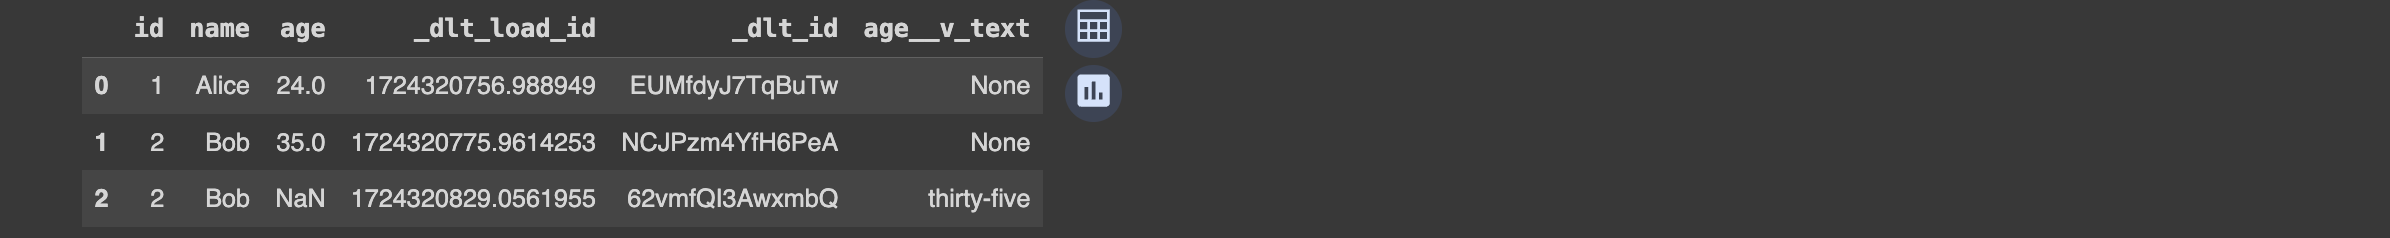

The `discard_row` mode at the data type level functions similarly to how it does at the column level. The only difference is that it discards rows with diverging data types instead of columns. As a result, you will see that Kate's data will not be loaded 👇.

In [18]:
# Define dlt resource that omits rows with unverifiable data types
@dlt.resource(schema_contract={"data_type": "discard_row"})
def discard_row(input_data):
   yield input_data

# Attempt to load two additional rows. Only the row where all column types can be validated will be loaded
load_info = data_type_pipeline.run(
    discard_row([
        {"id": 3, "name": "Sam", "age": "35"}, # This row will be loaded
        {"id": 4, "name": "Kate", "age": "seventy"} # This row will not be loaded
    ]),
    table_name="users"
)
print(load_info)

# View the data that has been loaded
print("\n")
conn = duckdb.connect(f"{data_type_pipeline.pipeline_name}.duckdb")
conn.sql("SELECT * FROM mydata.users").df()

Pipeline data_contracts_data_type load step completed in 0.04 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata
The duckdb destination used duckdb:////content/data_contracts_data_type.duckdb location to store data
Load package 1746872805.080475 is LOADED and contains no failed jobs




,id,name,age,_dlt_load_id,_dlt_id
0,1,Alice,24,1746872798.2443008,yiQlV50NHIHOKw
1,2,Bob,35,1746872801.7973866,LdMyyiSr+aebTg
2,3,Sam,35,1746872805.080475,22VHvZ9FVj7U2w


The same goes for the `discard_value` mode. However, note that when applied at the data type level, it will replace non-validating row items with `None`. So, in this example, Violetta's age will be set to `None` 👇.

In [19]:
# Define a dlt resource that replaces unverifiable values with None, but retains the rest of the row data
@dlt.resource(schema_contract={"data_type": "discard_value"})
def discard_value(input_data):
   yield input_data

# Load two additional rows. Since we're using the "discard_value" resource, both rows will be added
# However, the "age" value "twenty-eight" in the second row will be ignored and not loaded
load_info = data_type_pipeline.run(
    discard_value([
        {"id": 5, "name": "Sarah", "age": 23},
        {"id": 6, "name": "Violetta", "age": "twenty-eight"}
    ]),
    table_name="users"
)
print(load_info)

# View the data that has been loaded
print("\n")
conn = duckdb.connect(f"{data_type_pipeline.pipeline_name}.duckdb")
conn.sql("SELECT * FROM mydata.users").df()

Pipeline data_contracts_data_type load step completed in 0.04 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata
The duckdb destination used duckdb:////content/data_contracts_data_type.duckdb location to store data
Load package 1746872807.530349 is LOADED and contains no failed jobs




,id,name,age,_dlt_load_id,_dlt_id
0,1,Alice,24,1746872798.2443008,yiQlV50NHIHOKw
1,2,Bob,35,1746872801.7973866,LdMyyiSr+aebTg
2,3,Sam,35,1746872805.080475,22VHvZ9FVj7U2w
3,5,Sarah,23,1746872807.530349,8k1dn3amfFPQjw
4,6,Violetta,<NA>,1746872807.530349,WlUYik+mBzLrag


The `freeze` mode prohibits any changes to the data types of existing columns and will result in an error if there is a "breach in contract". The example below will fail.

In [20]:
# Define dlt resource that prevents any changes to the existing data types
@dlt.resource(schema_contract={"data_type": "freeze"})
def no_data_type_changes(input_data):
  yield input_data

# Attempt to load a row with a column value that can't be validated, in this case "forty"
# This will fail as no data type changes are allowed with the "no_data_type_changes" resource
load_info = data_type_pipeline.run(no_data_type_changes([{"id": 7, "name": "Lisa", "age": "forty"}]), table_name="users")
print(load_info)

PipelineStepFailed: Pipeline execution failed at stage normalize when processing package 1746872811.158744 with exception:

<class 'dlt.normalize.exceptions.NormalizeJobFailed'>
Job for users.94db34a286.typed-jsonl failed terminally in load 1746872811.158744 with message In schema: data_contracts_data_type: In Schema: data_contracts_data_type Table: users Column: age__v_text . Contract on data_type with mode freeze is violated. Trying to create new variant column age__v_text to table users but data_types are frozen..

# **Pydantic Models**

Pydantic models can also be used to [define table schemas and validate incoming data](https://dlthub.com/docs/general-usage/resource#define-a-schema-with-pydantic).
They can be passed directly to the "columns" argument of a `dlt` resource:
```python
class User(BaseModel):
    id: int
    name: str
    tags: List[str]
    email: Optional[str]
    address: Address
    status: Union[int, str]

@dlt.resource(name="user", columns=User)
def get_users():
    ...
```
This will set the schema contract to align with the default Pydantic behavior:
```python
{
  "tables": "evolve",
  "columns": "discard_value",
  "data_type": "freeze"
}
```

If you happen to pass a `schema_contract` explicitly along with the `columns` argument to a `dlt` resource, the following happens:

- `tables`: The contract will not impact the Pydantic model and will be applied when a new table is created.
- `columns`: The modes for columns are mapped into the `extra` modes of Pydantic. If your models contain other models, `dlt` will apply this setting recursively. The contract for columns is applied when a new column is created on an existing table.

<center>

| Column Mode     | Pydantic Extra |
|-----------------|----------------|
| evolve          | allow          |
| freeze          | forbid         |
| discard_value   | ignore         |
| discard_row     | forbid         |

</center>

- `data_type`: This supports the following modes for Pydantic:
  1. `evolve` will synthesize a lenient model that allows for any data type. It may result in variant columns upstream.
  2. `freeze` will re-raise a ValidationException.
  3. `discard_row` will remove the non-validating data items.
  4. `discard_value` is not currently supported.


# **Good to Know**

- Unless you specify a schema contract, settings will default to `evolve` on all levels.

- The `schema_contract` argument accepts two forms:
  1. Full form: A detailed mapping of schema entities to their respective contract modes.
  ```python
  schema_contract={"tables": "freeze", "columns": "freeze", "data_type": "freeze"}
  ```
  2. Shorthand form: A single contract mode that will be uniformly applied to all schema entities.
  ```python
  schema_contract="freeze"
  ```

- Schema contracts can be defined for:
  1. `dlt` resources: The contract applies to the corresponding table and any child tables.
  ```python
  @dlt.resource(schema_contract={"columns": "evolve"})
def items():
        ...
  ```
  2. `dlt` sources: The contract serves as a default for all resources within that source.
  ```python
  @dlt.source(schema_contract="freeze")
def source():
        ...
  ```
  3. The `pipeline.run()`: This contract overrides any existing schema contracts.
  ```python
  pipeline.run(source(), schema_contract="freeze")
  ```

- You can change the contract on a `dlt` source via its `schema_contract` property.
```python
source = dlt.source(...)
source.schema_contract = {"tables": "evolve", "columns": "freeze", "data_type": "discard_row"}
```

- To update the contract for `dlt` resources, use `apply_hints`.
```python
resource.apply_hints(schema_contract={"tables": "evolve", "columns": "freeze"})
```

- For the `discard_row` method at the table level, if there are two tables in a parent-child relationship, such as `users` and `users__addresses`, and the contract is violated in the child table, the row in the child table (`users__addresses`) will be discarded, while the corresponding parent row in the `users` table will still be loaded.

- If a table is a `new table` that hasn't been created on the destination yet, `dlt` will allow the creation of new columns. During the first pipeline run, the column mode is temporarily changed to `evolve` and then reverted back to the original mode. Following tables are considered new:
  1. Child tables inferred the nested data.
  2. Dynamic tables created from the data during extraction.
  3. Tables containing incomplete columns - columns without a data type bound to them.

  > Note that tables with columns defined with Pydantic models are not considered new.

✅ ▶ Proceed to the [next lesson](https://colab.research.google.com/drive/1YCjHWMyOO9QGC66t1a5bIxL-ZUeVKViR#forceEdit=true&sandboxMode=true)!